In [57]:
# Code Cell

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


In [58]:
# Code Cell

def lorenz(state, t, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def simulate_chaos(t, initial_state):
    return odeint(lorenz, initial_state, t)


In [59]:
# Code Cell

# Environment settings
env_size = 10  # Size of the 2D environment

# Targets
targets = [
    np.array([2, 4]),
    np.array([6, 4]),
    np.array([6, 1])
]

# Obstacles
obstacles = [
    np.array([4, 4]),
    np.array([6, 2])
]

# Agent settings
agent_position = np.array([0.0, 0.0])
agent_velocity = np.array([0.0, 0.0])
learning_rate = 0.05

# Simulation parameters
time_steps = 5000
dt = 0.1
chaos_weight = 0.5
chaos_decay = 0.55
chaos_state = [1.0, 1.0, 1.0]

# Multi-target prioritization settings
# Options: 'closest', 'furthest', 'sequence'
search_strategy = 'sequence'  # User can choose 'closest', 'furthest', or 'sequence'
target_sequence = [2, 0, 1]   # Indices of targets in the order to visit (used if 'sequence' is selected)


In [60]:
# Code Cell

def reward(agent_position, current_target):
    distance_to_target = np.linalg.norm(agent_position - current_target)
    if distance_to_target <= 1.5:
        return 1  # High reward near target
    return -0.1  # Penalize being away from the target


In [61]:
# Code Cell

def select_target(agent_position, targets, strategy, sequence, step):
    if strategy == 'closest':
        distances = [np.linalg.norm(agent_position - t) for t in targets]
        return targets[np.argmin(distances)]
    elif strategy == 'furthest':
        distances = [np.linalg.norm(agent_position - t) for t in targets]
        return targets[np.argmax(distances)]
    elif strategy == 'sequence':
        index = step // (time_steps // len(sequence))
        index = min(index, len(sequence) - 1)
        return targets[sequence[index]]
    else:
        raise ValueError("Invalid search strategy selected.")


In [62]:
# Code Cell

# Visualization setup
trajectory = [agent_position.copy()]
reward_history = []
visited_targets = set()
current_target = None

for step in range(time_steps):
    # Select current target
    current_target = select_target(agent_position, targets, search_strategy, target_sequence, step)
    
    # Check if the target has been reached
    if np.linalg.norm(agent_position - current_target) <= 1.5:
        visited_targets.add(tuple(current_target))
    
    # Calculate reward
    current_reward = reward(agent_position, current_target)
    reward_history.append(current_reward)
    
    # Calculate gradient towards target
    gradient = current_target - agent_position
    gradient_norm = np.linalg.norm(gradient)
    if gradient_norm > 0:
        gradient /= gradient_norm  # Normalize gradient
    
    # Chaotic dynamics contribution
    t = np.linspace(0, dt, 10)
    chaos_state = simulate_chaos(t, chaos_state)[-1]
    chaotic_force = chaos_state[:2]  # Use x and y components
    
    # Update agent's velocity and position
    agent_velocity = learning_rate * gradient + chaos_weight * chaotic_force
    agent_position += agent_velocity * dt
    trajectory.append(agent_position.copy())
    
    # Decay chaotic contribution
    chaos_weight *= chaos_decay


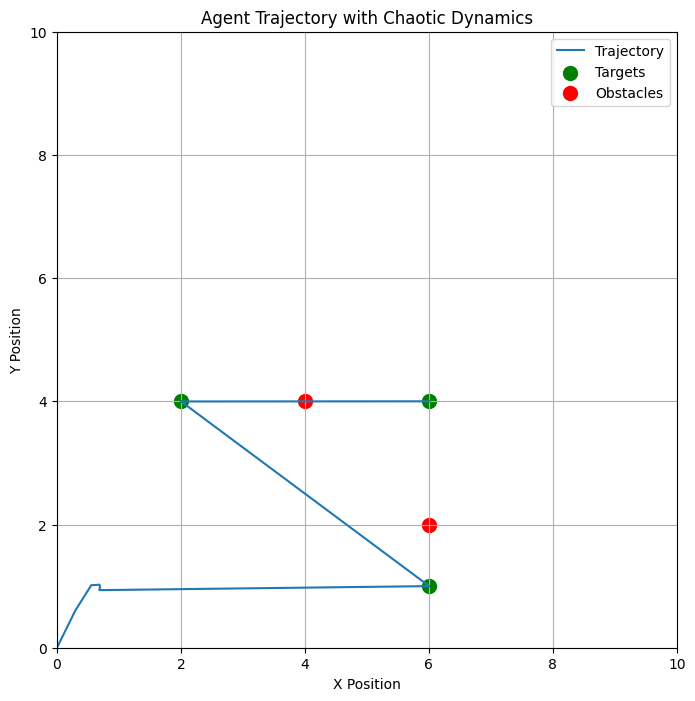

In [63]:
# Code Cell

trajectory = np.array(trajectory)
plt.figure(figsize=(8, 8))
plt.plot(trajectory[:, 0], trajectory[:, 1], label="Trajectory", linewidth=1.5)
plt.scatter(*np.array([t for t in targets]).T, color="green", label="Targets", s=100)
plt.scatter(*np.array(obstacles).T, color="red", label="Obstacles", s=100)
plt.title("Agent Trajectory with Chaotic Dynamics")
plt.xlim(0, env_size)
plt.ylim(0, env_size)
plt.legend()
plt.grid(True)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


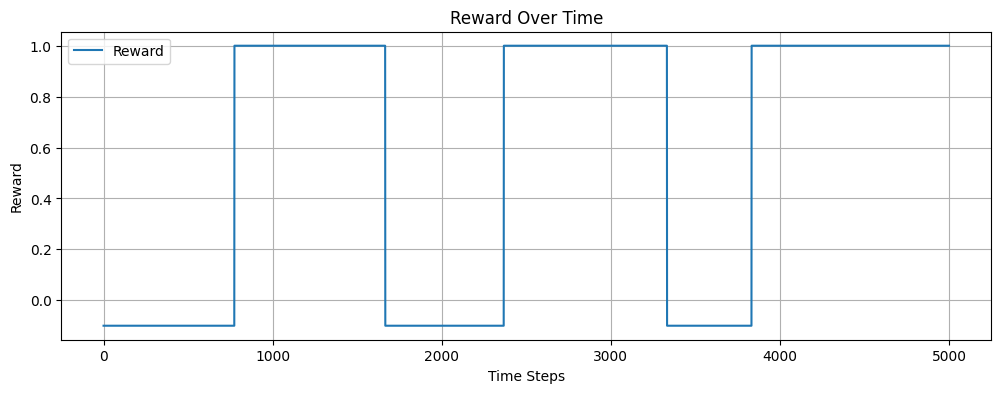

In [64]:
# Code Cell

plt.figure(figsize=(12, 4))
plt.plot(reward_history, label="Reward")
plt.title("Reward Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()
